In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pyswarms as ps
from sklearn.metrics import classification_report
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Divisão da base de dados e pré-processamento

In [15]:
base = pd.read_csv("abalone.csv")
base.info()

attributes = base.iloc[:, 1:9].values
sex = base.iloc[:, 0].values

scaler = MinMaxScaler(feature_range=(-1, 1))
attributes = scaler.fit_transform(attributes)

labelencoder = LabelEncoder()
sex = labelencoder.fit_transform(sex)

X_train, X_test, y_train, y_test =  train_test_split(attributes, sex, shuffle=True, random_state=1, test_size=.174)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


# Construção da topologia da RNA

In [16]:
n_inputs = 8
n_hidden = 20
n_classes = 3

num_samples = 3450

# Definição de função das camadas da RNA
def logits_function(p):
    W1 = p[0:160].reshape((n_inputs,n_hidden))
    b1 = p[160:180].reshape((n_hidden,))
    W2 = p[180:240].reshape((n_hidden,n_classes))
    b2 = p[240:243].reshape((n_classes,))

    z1 = X_train.dot(W1) + b1  
    a1 = np.tanh(z1)    
    logits = a1.dot(W2) + b2 
    return logits

# Definição da função da etapa foward do algoritmo BP
def forward_prop(params):
    logits = logits_function(params)

    exp_scores = np.exp(logits)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    corect_logprobs = -np.log(probs[range(num_samples), y_train])
    loss = np.sum(corect_logprobs) / num_samples

    return loss

# Definição da função para auxiliar na execução do PSO
def f(x):
    
    n_particles = x.shape[0]
    j = [forward_prop(x[i]) for i in range(n_particles)]
    return np.array(j)

# Inicialização PSO

In [17]:
options = {'c1': 0.15, 'c2': 0.5, 'w':0.9}

dimensions = (n_inputs * n_hidden) + (n_hidden * n_classes) + n_hidden + n_classes
optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=dimensions, options=options)

cost, pos = optimizer.optimize(f, iters=1000)


2021-11-08 11:29:42,992 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.15, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.833
2021-11-08 11:38:12,815 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.832627315426873, best pos: [-0.99233303  0.75710625  0.57278047  1.86721636  0.96441879  0.62865071
  2.57922012  0.61577839  1.47392932 -0.44095918  1.07005489  0.22801764
  0.89376728  0.56740662  0.94211279  1.60403299 -0.11808954 -3.24923057
  0.78716547  1.11771847 -0.14066611  0.41731962 -0.80015545  1.41877466
  1.05906988  2.92556752  1.01979678 -0.11041325  2.15050282  0.15212688
  0.73983443  0.65186731 -0.2619188   1.78319979 -0.59036743  0.35707966
  0.76737675  1.27588606  1.27536245  0.14351281  0.87646757  1.54107348
  1.41705917  0.22564989  0.92583366  1.26438923 -0.25500249 -0.26636282
 -0.30717495  0.19536394  0.38584705 -0.27433095 -0.28155692  0.23575625
 -0.0986453   0.44

# Previsão

In [26]:
def predict(pos):
    logits = logits_function(pos)
    y_pred = np.argmax(logits, axis=1)
    return y_pred

forecasts = predict(pos)
matrix = confusion_matrix(forecasts, y_train)
print(f"Acurácia: {(predict(pos) == y_train).mean()}")

Acurácia: 0.5733333333333334


Confusion matrix, without normalization
[[342  50 275]
 [151 899 243]
 [587 166 737]]


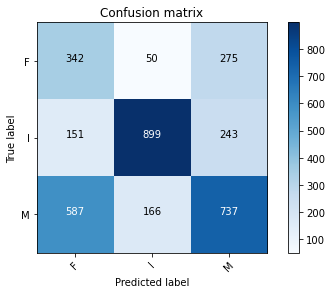

In [27]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(matrix,["F","I","M"])

<AxesSubplot:>

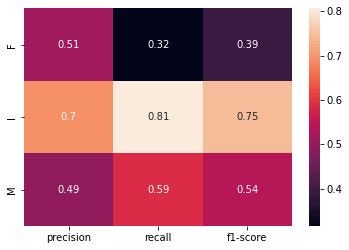

In [19]:
clf_report = classification_report(y_train, forecasts, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1,:-3].T, annot=True,yticklabels=["F","I","M"])